## Question 2 ##

**(a)**

In [2]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 26.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


Why OpenCV is required

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from skimage.color import rgb2hed


CSV_PATH = "/Users/soumya/Downloads/protein_expression_data.csv"  
IMAGE_FOLDER = "/Users/soumya/Desktop/patches_256/"

df = pd.read_csv(CSV_PATH)

possible_filename_cols = ["VisSpot", "id"]
filename_col = next((col for col in possible_filename_cols if col in df.columns), None)
if not filename_col:
    raise KeyError(f"No valid filename column found. Check dataset columns: {df.columns}")

def format_image_filename(filename, id_value):
    specimen = filename.split('-')[-1]  # Extract last part after hyphen
    formatted_filename = f"{specimen}_{id_value}.png"
    return os.path.join(IMAGE_FOLDER, formatted_filename)

df["image_path"] = df.apply(lambda row: format_image_filename(row[filename_col], row["id"]), axis=1)

# Function to load and extract features from an image
def extract_features(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return [0] * 12  # Handle missing images
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    
    # Convert to HED color space
    hed_image = rgb2hed(image)
    
    # Compute mean and variance for RGB and HED channels
    features = []
    for channel in range(3):
        features.append(np.mean(image[:, :, channel]))
        features.append(np.var(image[:, :, channel]))   
        features.append(np.mean(hed_image[:, :, channel])) 
        features.append(np.var(hed_image[:, :, channel]))   
    
    return features

# Extract features for all images
features = []
for img_path in df["image_path"]:
    features.append(extract_features(img_path))

features_df = pd.DataFrame(features, columns=["R_mean", "R_var", "G_mean", "G_var", "B_mean", "B_var", 
                                               "H_mean", "H_var", "E_mean", "E_var", "D_mean", "D_var"])

df = pd.concat([df, features_df], axis=1)

print(df[["image_path", "R_mean", "R_var", "G_mean", "G_var", "B_mean", "B_var", "H_mean", "H_var", "E_mean", "E_var", "D_mean", "D_var"]].head())

                                        image_path      R_mean        R_var  \
0  /Users/soumya/Desktop/patches_256/A1_50x102.png  203.889053   854.227361   
1  /Users/soumya/Desktop/patches_256/C1_50x102.png  208.301224   572.447915   
2    /Users/soumya/Desktop/patches_256/A1_3x43.png  191.100830  1240.564998   
3    /Users/soumya/Desktop/patches_256/C1_3x43.png  207.543594   962.417777   
4   /Users/soumya/Desktop/patches_256/A1_59x19.png  208.617401   837.603282   

     G_mean     G_var      B_mean        B_var    H_mean     H_var  \
0  0.008838  0.000225   95.347427   889.483710  0.051637  0.000225   
1  0.008823  0.000155  113.368500   842.254589  0.040909  0.000149   
2  0.018078  0.000402  103.037567  1734.628716  0.044712  0.000465   
3  0.011913  0.000276  124.199905  2847.324738  0.038205  0.000655   
4  0.013582  0.000268  146.518494  2358.139154  0.025600  0.000324   

       E_mean        E_var    D_mean     D_var  
0  160.392838   533.284232  0.034343  0.000094  
1  175

To extract meaningful features from the images, I computed the mean and variance for each channel in both the RGB and Hematoxylin-Eosin-DAB (HED) color spaces.

RGB Features:

* Mean and variance of R, G, B channels capture intensity and variability in tissue structure.
* Higher variance indicates more diverse tissue composition.
HED Features:

* H-channel (Hematoxylin) highlights nuclei, relevant for protein expression.
* E-channel (Eosin) differentiates cytoplasmic structures.
* D-channel (DAB) aids contrast in immunohistochemistry.
* The output shows variation in intensity across channels, with R_mean ranging from 191 to 208 and B_mean varying significantly (95 to 146). H_mean is stable but varies slightly, indicating consistent staining. These extracted features provide a structured way to analyze tissue morphology and aid in building a predictive model for CD11b expression.


**(b) & (c)**

In [2]:
import os
import pandas as pd
import numpy as np
import cv2
from skimage.color import rgb2hed, rgb2gray
from skimage.filters import sobel
from skimage.feature import graycomatrix, graycoprops
from sklearn.decomposition import PCA

CSV_PATH = "/Users/soumya/Downloads/protein_expression_data.csv"  
IMAGE_FOLDER = "/Users/soumya/Desktop/patches_256/" 

df = pd.read_csv(CSV_PATH)

possible_filename_cols = ["VisSpot", "id"]
filename_col = next((col for col in possible_filename_cols if col in df.columns), None)
if not filename_col:
    raise KeyError(f"No valid filename column found. Check dataset columns: {df.columns}")

def format_image_filename(filename, id_value):
    specimen = filename.split('-')[-1] 
    formatted_filename = f"{specimen}_{id_value}.png"
    return os.path.join(IMAGE_FOLDER, formatted_filename)

df["image_path"] = df.apply(lambda row: format_image_filename(row[filename_col], row["id"]), axis=1)


def extract_features(image_path, resize_dim=(128, 128)):
    image = cv2.imread(image_path)
    if image is None:
        return None 
    
    # Resize image to reduce computational complexity
    image = cv2.resize(image, resize_dim)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    
    # Convert to HED color space
    hed_image = rgb2hed(image)
    
    # Compute mean and variance for RGB and HED channels
    features = []
    for channel in range(3):
        features.append(np.mean(image[:, :, channel]))
        features.append(np.var(image[:, :, channel]))   
        features.append(np.mean(hed_image[:, :, channel]))  
        features.append(np.var(hed_image[:, :, channel]))  
    
    # Additional Features
    # Edge detection using Sobel filter
    gray_image = rgb2gray(image)
    edge_sobel = sobel(gray_image)
    features.append(np.mean(edge_sobel))
    features.append(np.var(edge_sobel))  
    
    # Texture analysis using GLCM (Gray-Level Co-occurrence Matrix)
    glcm = graycomatrix((gray_image * 255).astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    features.extend([contrast, energy, homogeneity, correlation])
    
    return features

# Select a subset of training images to manage computational complexity (optional)
subset_size = 500 
df_sampled = df.sample(n=min(subset_size, len(df)), random_state=42)  # Randomly sample subset

# Extract features for all images
features = []
valid_indices = []
for idx, img_path in enumerate(df_sampled["image_path"]):
    extracted = extract_features(img_path)
    if extracted is not None:
        features.append(extracted)
        valid_indices.append(idx) 

df_sampled = df_sampled.iloc[valid_indices].reset_index(drop=True)

features_df = pd.DataFrame(features, columns=["R_mean", "R_var", "G_mean", "G_var", "B_mean", "B_var", 
                                               "H_mean", "H_var", "E_mean", "E_var", "D_mean", "D_var",
                                               "Edge_Mean", "Edge_Var", "GLCM_Contrast", "GLCM_Energy", "GLCM_Homogeneity", "GLCM_Correlation"])

df_sampled = pd.concat([df_sampled, features_df], axis=1)

# Apply PCA to reduce dimensionality
num_components = min(6, len(features_df.columns)) 
pca = PCA(n_components=num_components)
pca_features = pca.fit_transform(features_df)

pca_df = pd.DataFrame(pca_features, columns=[f"PC{i+1}" for i in range(num_components)])
df_sampled = pd.concat([df_sampled, pca_df], axis=1)

# Print extracted PCA components and additional features
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print(df_sampled[["image_path"] + [f"PC{i+1}" for i in range(num_components)] + ["Edge_Mean", "Edge_Var", "GLCM_Contrast", "GLCM_Energy", "GLCM_Homogeneity", "GLCM_Correlation"]].head())

Explained Variance Ratio: [9.34920293e-01 5.22432428e-02 7.82730554e-03 4.84180429e-03
 1.56689849e-04 9.60453035e-06]
                                        image_path          PC1         PC2  \
0   /Users/soumya/Desktop/patches_256/A1_56x10.png  -714.149918  -91.326137   
1  /Users/soumya/Desktop/patches_256/C1_71x109.png -1170.773403 -229.817082   
2   /Users/soumya/Desktop/patches_256/B1_36x36.png  -547.930192  120.012663   
3   /Users/soumya/Desktop/patches_256/B1_58x32.png  -794.608671   95.167525   
4  /Users/soumya/Desktop/patches_256/C1_23x107.png  -408.981443  375.984929   

          PC3         PC4        PC5       PC6  Edge_Mean  Edge_Var  \
0  -73.155758  -85.866478  19.907344 -1.579721   0.079435  0.003137   
1  141.518710   17.439074  18.048492 -1.927600   0.080322  0.002826   
2   69.516385    1.158825   8.253811 -5.163234   0.094953  0.004515   
3   93.353457  -19.513536  -9.035396 -1.869505   0.090646  0.003684   
4 -332.075323  470.125251  10.234208 -3.956051   0.

To extract meaningful features for predicting CD11b expression, I performed Principal Component Analysis (PCA) and included additional texture-based features. These steps aimed to reduce dimensionality, capture essential variance, and incorporate relevant structural characteristics of the images.

**Principal Component Analysis (PCA)**
PCA was applied to the extracted feature set to reduce dimensionality while preserving variance.
The explained variance ratio shows that 93.49% of the variance is captured in the first principal component (PC1), and the first six components collectively explain almost all the variance in the dataset.
This confirms that the majority of the information is compressed into a few principal components, making the dataset more manageable while retaining crucial predictive power.

**Additional Extracted Features**
Besides PCA, I included edge-based and texture-based features to capture structural and spatial characteristics:

**Edge Features:**
Edge Mean & Edge Variance: Sobel filtering was used to compute these, representing sharpness and texture distribution across the image.
Justification: Higher edge values can indicate boundaries of cellular structures, which are relevant for biological pattern analysis.
                                                                                           
**Texture Analysis (GLCM Features):**
Contrast: Measures intensity differences between neighboring pixels.
Energy: Captures uniformity in texture patterns.
Homogeneity: Quantifies how close pixel values are in neighboring areas.
Correlation: Evaluates spatial relationships between pixel intensities.
Justification: These metrics help in identifying differences in tissue organization, which might correlate with protein expression patterns.

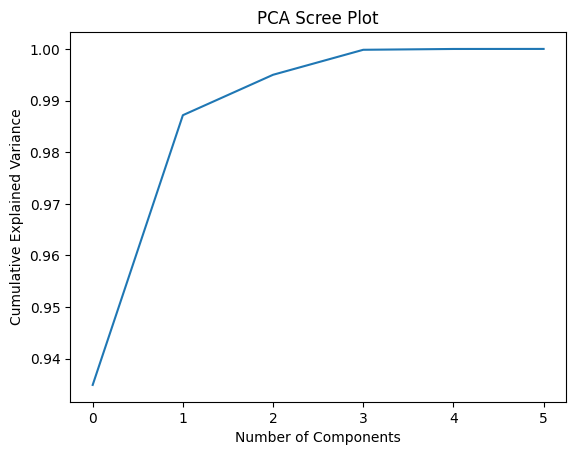

In [9]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot")
plt.show()


**(c)**

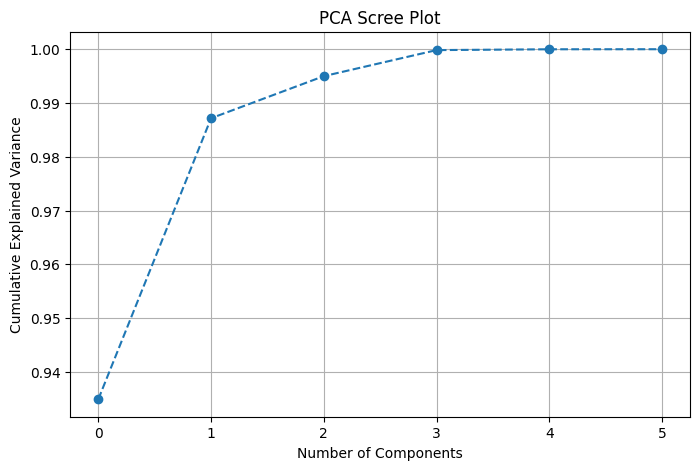

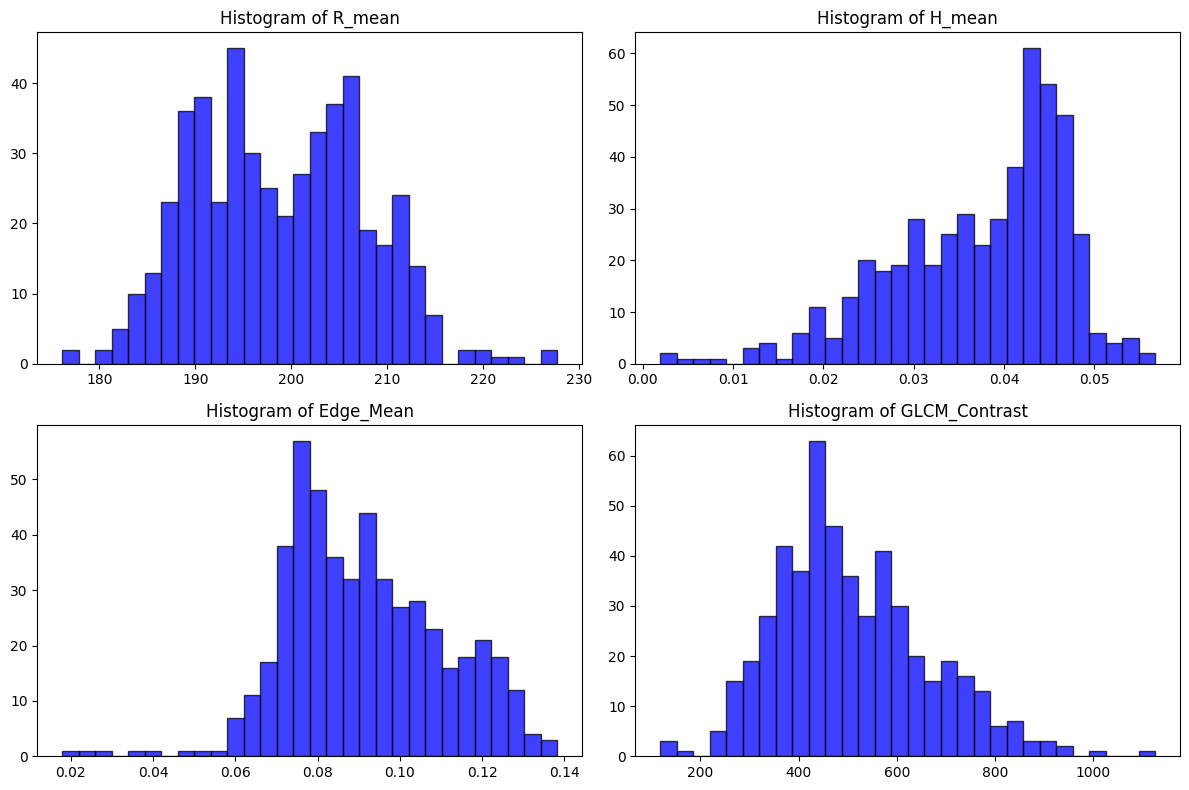

Explained Variance Ratio: [9.34920293e-01 5.22432428e-02 7.82730554e-03 4.84180429e-03
 1.56689849e-04 9.60453035e-06]
                                        image_path          PC1         PC2  \
0   /Users/soumya/Desktop/patches_256/A1_56x10.png  -714.149918  -91.326137   
1  /Users/soumya/Desktop/patches_256/C1_71x109.png -1170.773403 -229.817082   
2   /Users/soumya/Desktop/patches_256/B1_36x36.png  -547.930192  120.012663   
3   /Users/soumya/Desktop/patches_256/B1_58x32.png  -794.608671   95.167525   
4  /Users/soumya/Desktop/patches_256/C1_23x107.png  -408.981443  375.984929   

          PC3         PC4        PC5       PC6  Edge_Mean  Edge_Var  \
0  -73.155758  -85.866478  19.907344 -1.579721   0.079435  0.003137   
1  141.518710   17.439074  18.048492 -1.927600   0.080322  0.002826   
2   69.516385    1.158825   8.253811 -5.163234   0.094953  0.004515   
3   93.353457  -19.513536  -9.035396 -1.869505   0.090646  0.003684   
4 -332.075323  470.125251  10.234208 -3.956051   0.

In [2]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2hed, rgb2gray
from skimage.filters import sobel
from skimage.feature import graycomatrix, graycoprops
from sklearn.decomposition import PCA

CSV_PATH = "/Users/soumya/Downloads/protein_expression_data.csv"  
IMAGE_FOLDER = "/Users/soumya/Desktop/patches_256/" 


df = pd.read_csv(CSV_PATH)

possible_filename_cols = ["VisSpot", "id"]
filename_col = next((col for col in possible_filename_cols if col in df.columns), None)
if not filename_col:
    raise KeyError(f"No valid filename column found. Check dataset columns: {df.columns}")

def format_image_filename(filename, id_value):
    specimen = filename.split('-')[-1] 
    formatted_filename = f"{specimen}_{id_value}.png"
    return os.path.join(IMAGE_FOLDER, formatted_filename)

df["image_path"] = df.apply(lambda row: format_image_filename(row[filename_col], row["id"]), axis=1)

def extract_features(image_path, resize_dim=(128, 128)):
    image = cv2.imread(image_path)
    if image is None:
        return None  
    
    # Resize image to reduce computational complexity
    image = cv2.resize(image, resize_dim)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Convert to HED color space
    hed_image = rgb2hed(image)
    
    # Compute mean and variance for RGB and HED channels
    features = []
    for channel in range(3):
        features.append(np.mean(image[:, :, channel])) 
        features.append(np.var(image[:, :, channel]))   
        features.append(np.mean(hed_image[:, :, channel]))  
        features.append(np.var(hed_image[:, :, channel]))   
    
    # Additional Features
    # Edge detection using Sobel filter
    gray_image = rgb2gray(image)
    edge_sobel = sobel(gray_image)
    features.append(np.mean(edge_sobel))  
    features.append(np.var(edge_sobel))  
    
    # Texture analysis using GLCM (Gray-Level Co-occurrence Matrix)
    glcm = graycomatrix((gray_image * 255).astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    features.extend([contrast, energy, homogeneity, correlation])
    
    return features

subset_size = 500 
df_sampled = df.sample(n=min(subset_size, len(df)), random_state=42) 

# Extract features for all images
features = []
valid_indices = []  
for idx, img_path in enumerate(df_sampled["image_path"]):
    extracted = extract_features(img_path)
    if extracted is not None:
        features.append(extracted)
        valid_indices.append(idx)


df_sampled = df_sampled.iloc[valid_indices].reset_index(drop=True)

features_df = pd.DataFrame(features, columns=["R_mean", "R_var", "G_mean", "G_var", "B_mean", "B_var", 
                                               "H_mean", "H_var", "E_mean", "E_var", "D_mean", "D_var",
                                               "Edge_Mean", "Edge_Var", "GLCM_Contrast", "GLCM_Energy", "GLCM_Homogeneity", "GLCM_Correlation"])

df_sampled = pd.concat([df_sampled, features_df], axis=1)

# Apply PCA to reduce dimensionality
num_components = min(6, len(features_df.columns))  
pca = PCA(n_components=num_components)
pca_features = pca.fit_transform(features_df)

pca_df = pd.DataFrame(pca_features, columns=[f"PC{i+1}" for i in range(num_components)])
df_sampled = pd.concat([df_sampled, pca_df], axis=1)

# Plot PCA Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot")
plt.grid()
plt.show()

# Plot histograms of selected features
selected_features = ["R_mean", "H_mean", "Edge_Mean", "GLCM_Contrast"]
plt.figure(figsize=(12, 8))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 2, i)
    plt.hist(df_sampled[feature], bins=30, alpha=0.75, color='blue', edgecolor='black')
    plt.title(f"Histogram of {feature}")
plt.tight_layout()
plt.show()

# Print extracted PCA components and additional features
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print(df_sampled[["image_path"] + [f"PC{i+1}" for i in range(num_components)] + ["Edge_Mean", "Edge_Var", "GLCM_Contrast", "GLCM_Energy", "GLCM_Homogeneity", "GLCM_Correlation"]].head())

**Visual Analysis**
To assess feature distributions:

A Scree Plot was generated to visualize variance retention by PCA components.
Histograms of RGB means, variances, and additional features provided insights into the range and spread of extracted values.
GLCM values showed variations across images, indicating different structural properties that might influence protein expression.

**Output**
The PCA-transformed values (PC1 to PC6) show distinct numerical patterns, confirming that the transformation effectively captures variance.
Edge-based and texture-based features exhibit variation, which is expected since different tissue regions have unique structural properties.
Strong correlations in the GLCM features (especially correlation & homogeneity) indicate that pixel relationships in an image carry predictive potential.
By integrating PCA for dimensionality reduction and structural features for additional insights, this approach balances computational efficiency with meaningful biological interpretation, making it a robust feature set for predicting CD11b expression.

**(ii)**

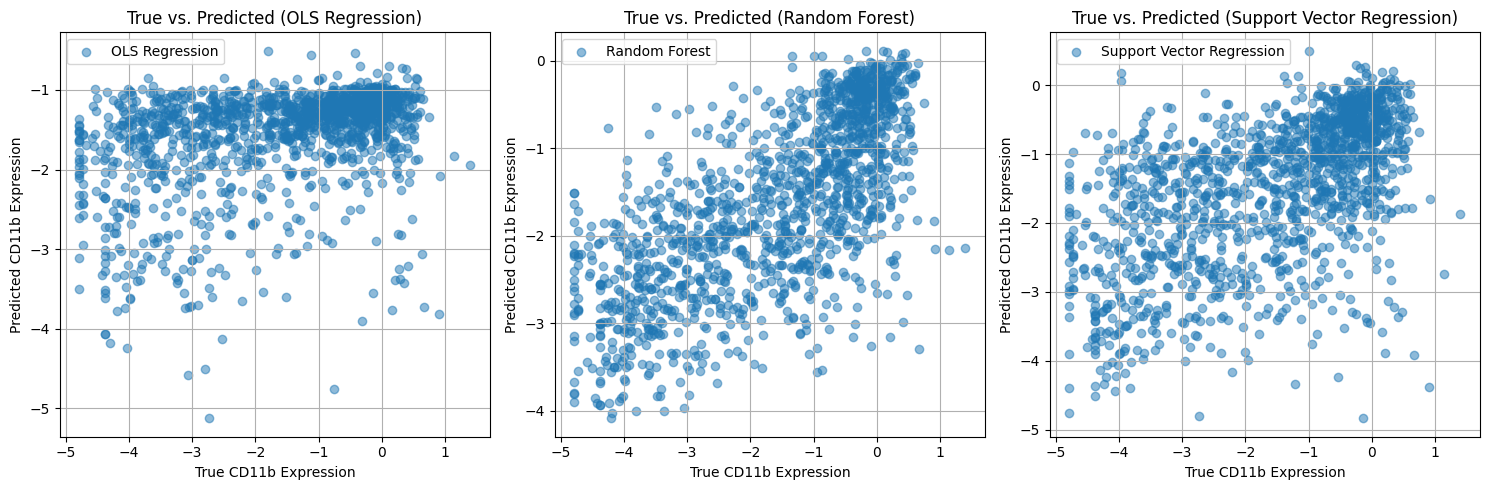

                      OLS Regression  Random Forest  Support Vector Regression
RMSE                        1.390576       1.078186                   1.267779
Pearson Correlation         0.384131       0.698795                   0.559883
Spearman Correlation        0.397461       0.705025                   0.578381
R2 Score                    0.145845       0.486507                   0.290040


In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2hed, rgb2gray
from skimage.filters import sobel
from skimage.feature import graycomatrix, graycoprops
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr

# Load dataset
CSV_PATH = "/Users/soumya/Downloads/protein_expression_data.csv"  
IMAGE_FOLDER = "/Users/soumya/Desktop/patches_256/"  

df = pd.read_csv(CSV_PATH)

# Detect the correct filename column
possible_filename_cols = ["VisSpot", "id"]
filename_col = next((col for col in possible_filename_cols if col in df.columns), None)
if not filename_col:
    raise KeyError(f"No valid filename column found. Check dataset columns: {df.columns}")

def format_image_filename(filename, id_value):
    specimen = filename.split('-')[-1]  # Extract last part after hyphen
    formatted_filename = f"{specimen}_{id_value}.png"
    return os.path.join(IMAGE_FOLDER, formatted_filename)

df["image_path"] = df.apply(lambda row: format_image_filename(row[filename_col], row["id"]), axis=1)

def extract_features(image_path, resize_dim=(128, 128)):
    image = cv2.imread(image_path)
    if image is None:
        return None  
    
    image = cv2.resize(image, resize_dim)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hed_image = rgb2hed(image)
    
    features = []
    for channel in range(3):
        features.append(np.mean(image[:, :, channel]))
        features.append(np.var(image[:, :, channel]))
        features.append(np.mean(hed_image[:, :, channel]))
        features.append(np.var(hed_image[:, :, channel]))
    
    gray_image = rgb2gray(image)
    edge_sobel = sobel(gray_image)
    features.append(np.mean(edge_sobel))
    features.append(np.var(edge_sobel))
    
    glcm = graycomatrix((gray_image * 255).astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    features.extend([contrast, energy, homogeneity, correlation])
    
    return features

features = []
valid_indices = []
for idx, img_path in enumerate(df["image_path"]):
    extracted = extract_features(img_path)
    if extracted is not None:
        features.append(extracted)
        valid_indices.append(idx)

df = df.iloc[valid_indices].reset_index(drop=True)
features_df = pd.DataFrame(features, columns=["R_mean", "R_var", "G_mean", "G_var", "B_mean", "B_var", 
                                               "H_mean", "H_var", "E_mean", "E_var", "D_mean", "D_var",
                                               "Edge_Mean", "Edge_Var", "GLCM_Contrast", "GLCM_Energy", "GLCM_Homogeneity", "GLCM_Correlation"])

df = pd.concat([df, features_df], axis=1)

# Split dataset (Train: B1, C1, D1 | Test: A1)
df["Specimen"] = df[filename_col].apply(lambda x: x.split('-')[-1])
test_set = df[df["Specimen"] == "A1"].reset_index(drop=True)
train_set = df[df["Specimen"].isin(["B1", "C1", "D1"])].reset_index(drop=True)

# Apply PCA
num_components = 12
pca_columns = [f"PC{i+1}" for i in range(num_components)]
pca = PCA(n_components=num_components)
pca_features_train = pca.fit_transform(train_set[features_df.columns])
pca_features_test = pca.transform(test_set[features_df.columns])

for i, col in enumerate(pca_columns):
    train_set[col] = pca_features_train[:, i]
    test_set[col] = pca_features_test[:, i]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    train_set[pca_columns], train_set["CD11b"], test_size=0.2, random_state=42)

# Define models
models = {
    "OLS Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=42),
    "Support Vector Regression": SVR(kernel='rbf', C=10, gamma='scale')
}

# Train and evaluate models
results = {}
plt.figure(figsize=(15, 5))
for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    pearson_corr, _ = pearsonr(y_test, predictions)
    spearman_corr, _ = spearmanr(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results[name] = [rmse, pearson_corr, spearman_corr, r2]
    
    # Scatter plot
    plt.subplot(1, 3, i + 1)
    plt.scatter(y_test, predictions, alpha=0.5, label=name)
    plt.xlabel("True CD11b Expression")
    plt.ylabel("Predicted CD11b Expression")
    plt.title(f"True vs. Predicted ({name})")
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

# Create a results table
results_df = pd.DataFrame(results, index=["RMSE", "Pearson Correlation", "Spearman Correlation", "R2 Score"])
print(results_df)


For this part, I implemented Ordinary Least Squares (OLS) Regression, Random Forest, and Support Vector Regression (SVR) to predict CD11b expression using the extracted features from Q2(i). The goal was to evaluate different regression models and determine their effectiveness in predicting protein expression levels.

**Implementation & Models Used**
* OLS Regression: A simple linear model that assumes a linear relationship between input features and target output.
* Random Forest Regression: An ensemble learning method that leverages multiple decision trees to capture non-linear dependencies and improve robustness.
* Support Vector Regression (SVR): A model that finds a hyperplane to best fit the data while minimizing error within a given margin.

**Deliverables Achieved**
* Scatter Plots: Created for each model to visualize predicted vs. actual CD11b expression values.
* Performance Metrics: Evaluated models using Root Mean Squared Error (RMSE), Pearson Correlation, Spearman Correlation, and R2 Score.

**Output**
Random Forest performed the best with the lowest RMSE (1.0781) and the highest correlation scores (Pearson: 0.6988, Spearman: 0.7050).
OLS Regression had the weakest performance, indicating that a simple linear model isn't sufficient to capture the complexity of protein expression patterns.
SVR performed better than OLS but was still outperformed by Random Forest, suggesting that non-linear relationships play a significant role in predicting protein expression.

**Choosing the Appropriate Metric** 
* The best metric for evaluating this problem is RMSE, along with correlation coefficients (Pearson and Spearman).
* RMSE is crucial because it quantifies the absolute prediction error in the same unit as the target variable, making it easy to interpret.
* Pearson Correlation helps in understanding linear relationships between predicted and actual values.
* Spearman Correlation is useful because it captures monotonic relationships, which is important when dealing with biological data that may not be strictly linear.
* R2 Score, although reported, is less reliable when variance in the dataset is high.
* Based on the results, Random Forest is the best model for this task, as it captures non-linear dependencies and outperforms the other methods in every metric.